Desenvolvemos aqui um modelo para predição de gasto mensal, utilizando idéias obtidas na análise dos dados.
Considerando os dados da aquisição e de gastos, desejamos ao final estimar quanto, aproximadamente, um novo cliente gastará por mês.

# Inicialização

In [1]:
# Imports necessários
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

import missingno as msno
import gc

from ast import literal_eval

style.use('bmh')

%matplotlib inline

In [2]:
# Lendo os conjuntos de dados
acq_train = pd.read_csv('../data/acquisition_train.csv')
acq_test = pd.read_csv('../data/acquisition_test.csv')
spend_train = pd.read_csv('../data/spend_train.csv')

# Limpeza dos dados

## Manipulação de dados

Aplicamos aqui os mesmos procedimentos aplicados antes da análise exploratória:

- Criamos uma váriavel binária para indicar os valores conhecidos de fraude 
- Fazemos o *parsing* do horário de *application*, e guardamos apenas a hora do dia
- Fazemos o *parsing* de `lat_lon` em duas novas colunas
- Eliminamos a coluna de primeiro nome, pois não devem influenciar casos de fraude ou inadimplência
- Alguns campos possuem valor infinito. Mudamos estes para ausentes (NaN)
- Criamos listas para ajudar a discernir os diferentes tipos de variáveis

In [3]:
acq_train['target_fraud_bin'] = acq_train['target_fraud'].apply(lambda x : False if pd.isna(x) else True)

In [4]:
parse_time_hour = lambda x: x.split(':')[0]

acq_train['application_hour_applied'] = pd.to_numeric(acq_train['application_time_applied'].apply(parse_time_hour)).replace(24,0)
acq_train.drop('application_time_applied',inplace=True, axis=1)

acq_test['application_hour_applied'] = pd.to_numeric(acq_test['application_time_applied'].apply(parse_time_hour)).replace(24,0)
acq_test.drop('application_time_applied',inplace=True, axis=1)

In [5]:
def lat_lon_parse (df):
    df['lat_lon'] = df['lat_lon'].apply(lambda x: literal_eval(x) if pd.notnull(x) else x)
    df[['lat','lon']] = df['lat_lon'].apply(pd.Series)
    df.drop('lat_lon', inplace=True, axis=1)
    
lat_lon_parse(acq_train)
lat_lon_parse(acq_test)

In [6]:
acq_train.drop('external_data_provider_first_name',inplace=True,axis=1)
acq_test.drop('external_data_provider_first_name',inplace=True,axis=1)

In [7]:
category = ['ids',
 'score_1',
 'score_2',
 'shipping_zip_code',
 'reason',
 'state',
 'zip',
 'job_name',
 'real_state',
 'user_agent',
 'email',
 'shipping_state',
 'marketing_channel'
]

binary = ['target_default',     
         'target_fraud_bin',
         'facebook_profile'
         ]

discrete = ['last_borrowed_in_months',
 'application_hour_applied',
  'ok_since',
 'n_bankruptcies',
 'n_defaulted_loans',
 'n_accounts',
 'n_issues',
 'external_data_provider_credit_checks_last_2_year',
 'external_data_provider_credit_checks_last_month',
 'external_data_provider_credit_checks_last_year',
  'external_data_provider_email_seen_before'
]

continuous = ['score_3',
 'score_4',
 'score_5',
 'score_6',
 'risk_rate',
 'last_amount_borrowed',
 'application_time_in_funnel',
 'credit_limit',
 'income',
 'reported_income',    
 'external_data_provider_fraud_score']

geo = ['lat','lon']

for c in category:
    acq_train[c] = acq_train[c].astype('category')
    acq_test[c] = acq_test[c].astype('category')
    

In [8]:
# Ajustar valores de income
acq_train.replace(np.inf,np.nan, inplace=True)
acq_test.replace(np.inf,np.nan, inplace=True)

E aplicamos mais alguns passos:

- `channel` só possui um valor, então podemos eliminá-la pois não interfere no modelo
- Consertamos alguns *typos* em `email`

In [9]:
cols_todrop = ['channel']
acq_train.drop(cols_todrop,axis=1,inplace=True)
acq_test.drop(cols_todrop,axis=1,inplace=True)

In [10]:
# Email typos

def clean_replace(df, replace_dict):
    for key in replace_dict:
        for entry in replace_dict[key]:
            df[key].replace(entry[0],entry[1],inplace=True)
            

replace_dict = {}
replace_dict['email'] = [['gmaill.com','gmail.com'],['hotmaill.com','hotmail.com']]

clean_replace(acq_train,replace_dict)
clean_replace(acq_test,replace_dict)

Fazemos ainda o *parsing* de `profile_tags`:

In [11]:
tags = []

def parse_tag(x):
    prof_tags = literal_eval(x)['tags']
    
    for t in prof_tags:
        if t not in tags:
            tags.append(t)

    return prof_tags

acq_train['parsed_tags'] = acq_train['profile_tags'].apply(parse_tag)
acq_test['parsed_tags'] = acq_test['profile_tags'].apply(parse_tag)

In [12]:
for t in tags:
    vals = []

    for row in acq_train['parsed_tags']:
        if t in row:
            vals.append(True)
        else: vals.append(False)
    acq_train['profile_' + t] = vals
    
    vals = []
    for row in acq_test['parsed_tags']:
        if t in row:
            vals.append(True)
        else: vals.append(False)
    acq_test['profile_' + t] = vals
    
tag_cats = ['profile_' + t for t in tags]
        

## Dados de gastos

Analisamos aqui os dados de gastos dos usuários. Definimos o "perfil" de um cliente pelos dados agregados ao longo dos meses, agrupados por `id`.

In [13]:
# Gerando aggregate dataframe de gastos
# Tomamos somente 'min' de credit_line porque todos os valores são iguais para um usuário

agg_spend = spend_train.groupby('ids').agg(
    {'credit_line':['min'],
     'month':['max'],
     'spends':['min','max','mean','median', 'sum'],
     'revolving_balance':['min','max','mean','median', 'sum'],
     'card_request':['sum'],
     'minutes_cs':['sum']
    }
    )

agg_spend.columns = ['_'.join(col).strip() for col in agg_spend.columns.values]
agg_spend.rename(index=str, columns={"month_max": "month", "credit_line_min": "credit_line"}, inplace=True)

# Fazemos um merge no mês, que corresponde ao último mês do usuário, de modo a ter disponível 
# o último gasto e a última dívida rolada.
# Merge feito também em credit_line para evitar campos duplicados
agg_spend = pd.merge(spend_train,agg_spend, on=['ids','month', 'credit_line'], how='inner').\
    rename(index=str, columns={"spends": "last_spend", "revolving_balance": "last_revolving"})

Definimos a coluna `profit` como o lucro dado por um cliente. Este campo leva em conta os valores de custos e taxas dados na descrição do problema.

In [14]:
def profit_value(row):
    return 0.995*(0.17*row['revolving_balance_sum']+
            + 0.03*row['spends_sum']
            - 10*row['card_request_sum']
            - 2.5*row['minutes_cs_sum'])
    
agg_spend['profit'] = agg_spend.apply(profit_value,axis=1)

Por fim, criamos um dataset conjunto, com os dados de aquisição e de compras para cada cliente.

In [15]:
df_train = pd.merge(acq_train, agg_spend, on='ids')

## Valores ausentes

Preenchemos com a mediana variáveis contínuas e com o valor mais frequente as variáveis discretas, além de `facebook_profile`.

In [16]:
from sklearn.preprocessing import Imputer
    
cols_fill_median = continuous
cols_fill_mostfreq = discrete + ['facebook_profile']

imp = Imputer(strategy='median')
imp.fit(df_train[cols_fill_median])
df_train[cols_fill_median] = imp.transform(df_train[cols_fill_median])
acq_test[cols_fill_median] = imp.transform(acq_test[cols_fill_median])

imp = Imputer(strategy='most_frequent')
imp.fit_transform(df_train[cols_fill_mostfreq])
df_train[cols_fill_mostfreq] = imp.transform(df_train[cols_fill_mostfreq])
acq_test[cols_fill_mostfreq] = imp.transform(acq_test[cols_fill_mostfreq])


## One-hot encoding

Aplicamos one-hot encoding em valores categóricos com até 10 valores únicos. Este limite é imposto para evitar muitas colunas no dataset.

In [17]:
def OHE_by_unique(train, one_hot, limit):
    
    one_hot_cat = []
    
    df = train.copy()
    for c in one_hot:
        if len(one_hot[c])>2 and len(one_hot[c]) < limit:
            for val in one_hot[c]:
                df[c+'_oh_' + str(val)] = (df[c].values == val).astype(np.int)
                one_hot_cat.append(c+'_oh_' + str(val))
                
    return df, one_hot_cat

In [18]:
one_hot = {c: list(acq_train[c].unique()) for c in category if c not in ['ids']}

In [19]:
train_ohe, one_hot_cat = OHE_by_unique(df_train, one_hot, 10)
test_ohe, _ = OHE_by_unique(acq_test, one_hot, 10)

# Modelagem

Definimos como alvo a mediana dos gastos de um cliente. Escolhemos a mediana e não a média por ser mais robusta a variações, e melhor representar o perfil de gastos de uma pessoa.

In [20]:
target = 'spends_median'

## Remoção de outliers

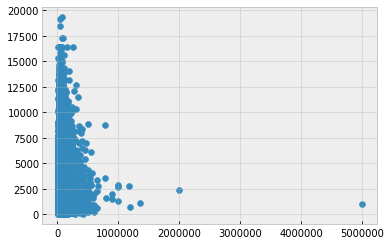

In [21]:
plt.scatter(train_ohe['income'],train_ohe[target])

In [22]:
train_ohe = train_ohe[(train_ohe['income']<800000)]

## Análise das distribuições

Analisamos a seguir a distribuição de algumas das variáveis, para que possamos escolher quais precisam de transformação, e que tipo. Fazemos *scaling* de algumas para evitar que distribuições com viés muito grande acabem por influenciar demais o modelo.

In [23]:
dist_vars = ['credit_limit', 'income','ok_since','n_bankruptcies', 
             'n_defaulted_loans', 'n_accounts', 'n_issues', target]

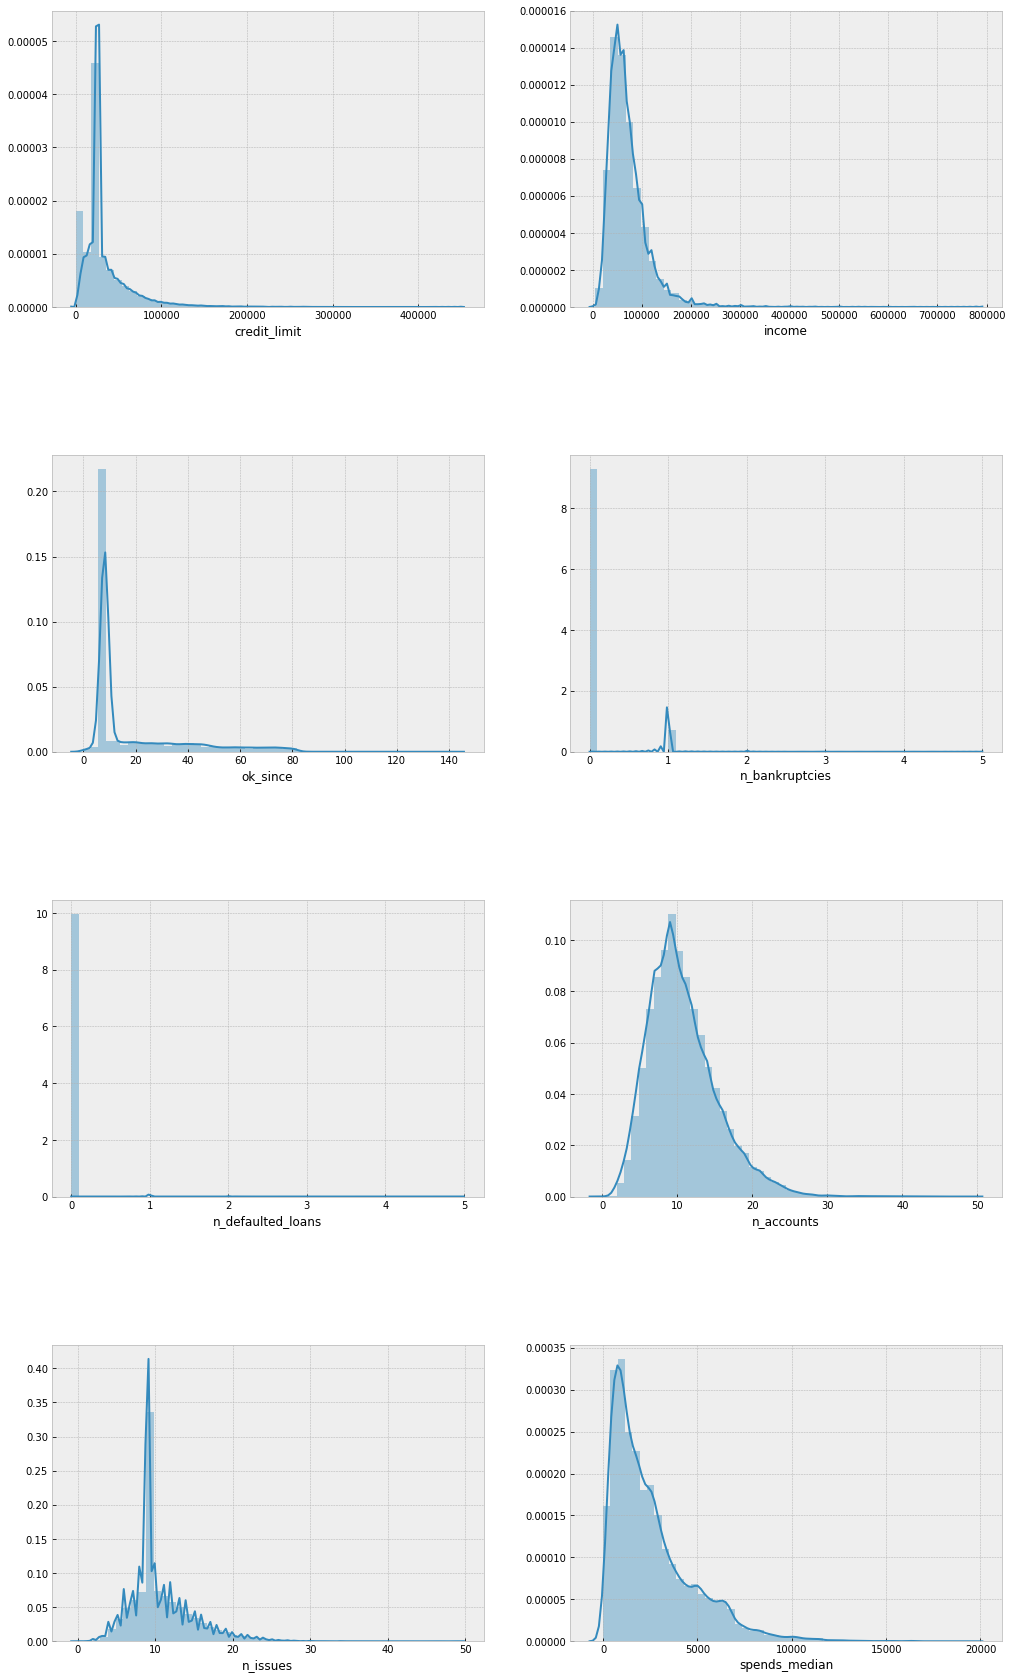

In [24]:
fig, axs = plt.subplots(int(len(dist_vars)/2),2, figsize=(16, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2, right=0.95)

axs = axs.ravel()

for ind, col in enumerate(train_ohe[dist_vars]):
    sns.distplot(train_ohe[col], ax = axs[ind])
    
plt.show()

Tomamos aquelas que são muito enviesadas e aplicamos `log`. Para outras que tem menor viés, aplicamos a raíz cúbica.

In [25]:
unskew_log = ['credit_limit', 'income','ok_since']
unskew_rt = ['n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues']
unskew = unskew_log + unskew_rt

train_ohe[unskew_rt] = np.cbrt(train_ohe[unskew_rt])
train_ohe[target] = np.cbrt(train_ohe[target])
train_ohe[unskew_log] = np.log1p(train_ohe[unskew_log])

test_ohe[unskew_rt] = np.cbrt(test_ohe[unskew_rt])
test_ohe[unskew_log] = np.log1p(test_ohe[unskew_log])

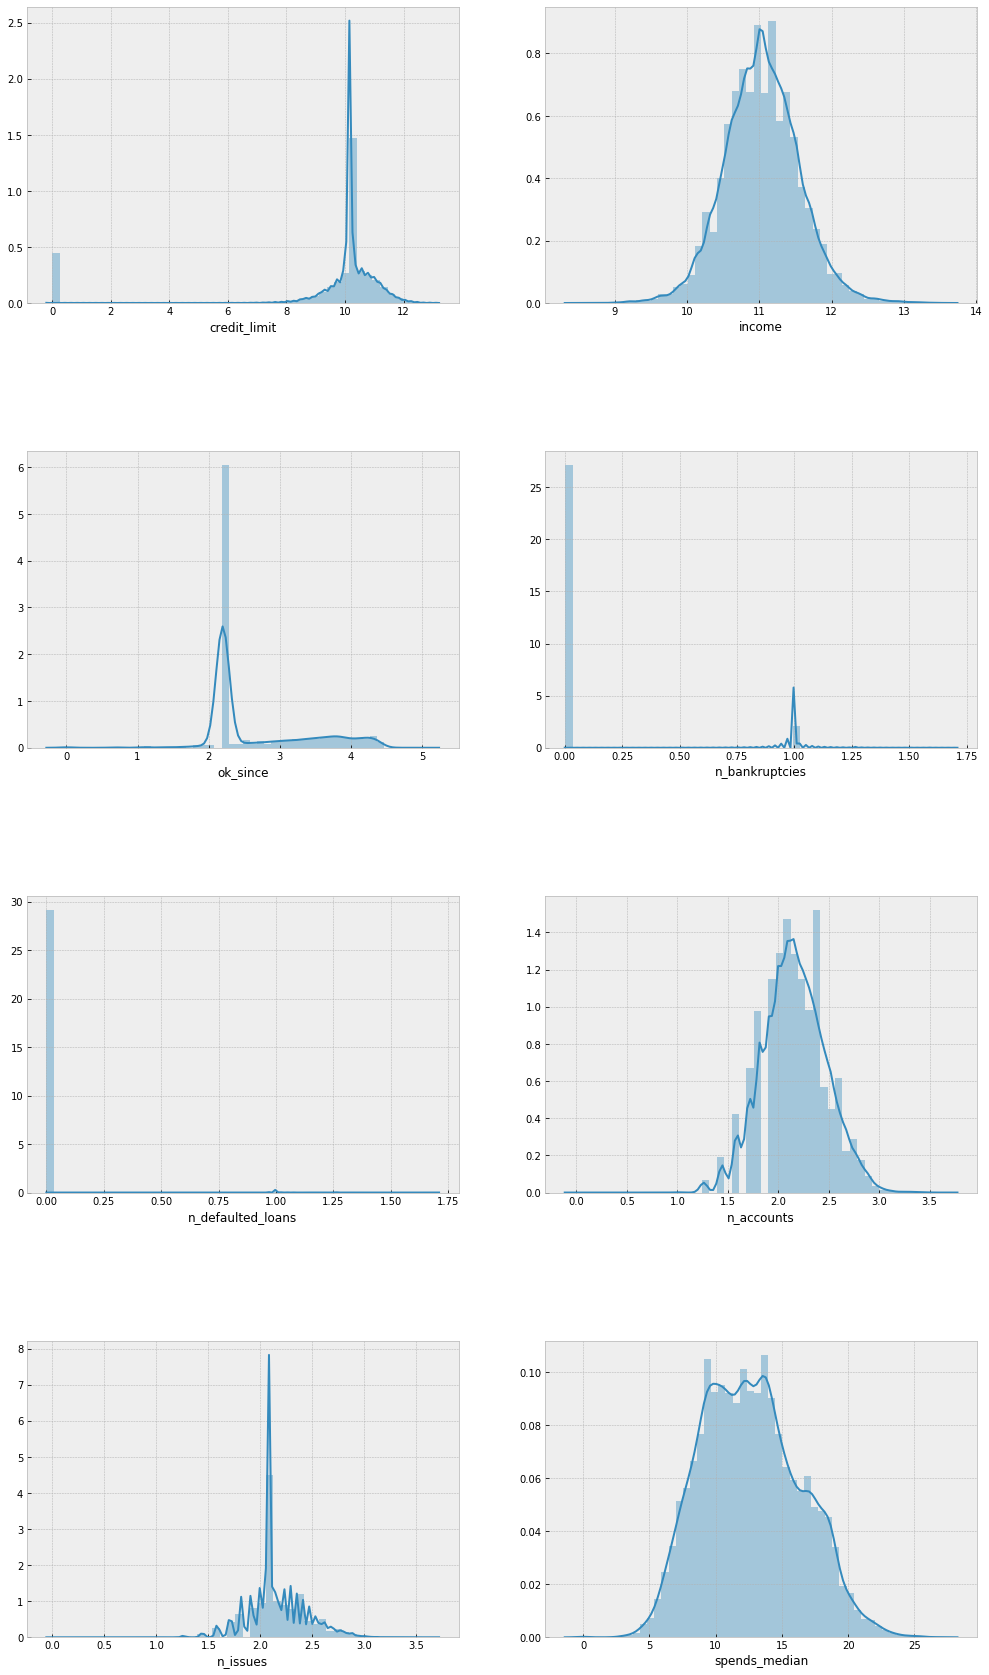

In [26]:
fig, axs = plt.subplots(int((len(unskew)+1)/2),2, figsize=(16, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2, right=0.95)

axs = axs.ravel()

for ind, col in enumerate(train_ohe[unskew+[target]]):
    sns.distplot(train_ohe[col], ax = axs[ind])
    
plt.show()

In [27]:
all_variables = continuous + discrete + tag_cats + one_hot_cat + [target]

In [29]:
from sklearn.preprocessing import StandardScaler

spend_std = train_ohe[target].std()
spend_mean = train_ohe[target].mean()

input_only = [v for v in all_variables if v != target]

scaler = StandardScaler()
scaler.fit(train_ohe[input_only])
train_ohe[input_only] = scaler.transform(train_ohe[input_only])
test_ohe[input_only] = scaler.transform(test_ohe[input_only])

train_ohe[target] = scaler.fit_transform(train_ohe[target].values.reshape(-1,1))

## Seleção de *features*

### RandomForestRegressor

Definido o target, treinamos um modelo simples de RandomForestRegressor e vemos quais são as principais features consideradas.

In [30]:
def get_feature_importance_df(feature_importances, 
                              column_names, 
                              top_n=25):
    """Get feature importance data frame.
 
    Parameters
    ----------
    feature_importances : numpy ndarray
        Feature importances computed by an ensemble 
            model like random forest or boosting
    column_names : array-like
        Names of the columns in the same order as feature 
            importances
    top_n : integer
        Number of top features
 
    Returns
    -------
    df : a Pandas data frame
 
    """
     
    imp_dict = dict(zip(column_names, 
                        feature_importances))
    top_features = sorted(imp_dict, 
                          key=imp_dict.get, 
                          reverse=True)[0:top_n]
    top_importances = [imp_dict[feature] for feature 
                          in top_features]
    df = pd.DataFrame(data={'feature': top_features, 
                            'importance': top_importances})
    return df

In [31]:
train = train_ohe[all_variables]

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=150, max_depth=12, min_samples_leaf=10, max_features=0.2, n_jobs=-1, random_state=42)
rf.fit(train.drop([target],axis=1), train[target])
features = train.drop([target],axis=1).columns.values

In [32]:
feature_importance = get_feature_importance_df(rf.feature_importances_, features)

O gráfico a seguir mostra as variáveis mais importantes de acordo com o modelo:

[Text(0, 0.5, 'Nome da variável'),
 Text(0.5, 0, 'Importância'),
 Text(0.5, 1.0, 'Importância das variáveis')]

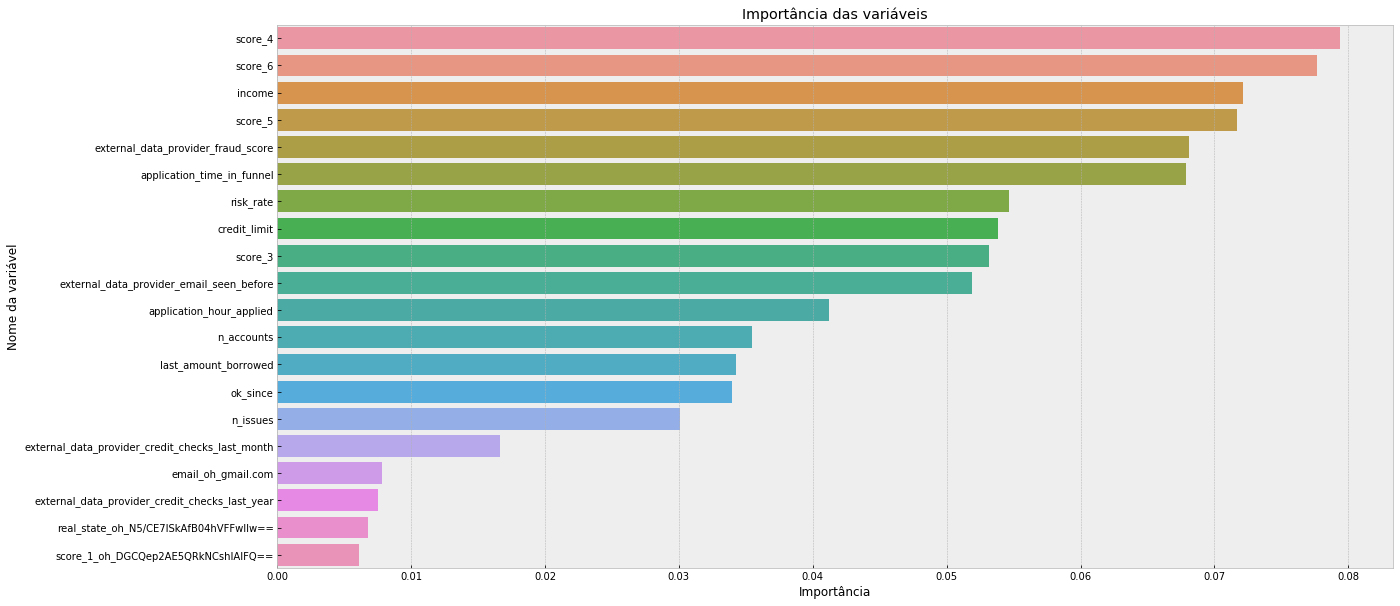

In [33]:
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(data=feature_importance[:20],y="feature",x="importance",ax=ax)
ax.set(ylabel='Nome da variável', xlabel='Importância',title="Importância das variáveis")

Utilizaremos estas variáveis no nosso modelo final.

In [34]:
variables = feature_importance[:12].feature.tolist()

In [35]:
def cross_val_model(X,y, model, n_splits=5):
    from sklearn.model_selection import KFold
    from sklearn.model_selection import cross_val_score
    X = np.array(X)
    y = np.array(y)


    folds = list(KFold(shuffle=True, n_splits=n_splits, random_state=42).split(X, y))

    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='neg_median_absolute_error')
        print("    cross_score: %.5f" % cross_score.mean())

Escolhemos como métrica `neg_median_absolute_error`, uma medida do erro absoluto entre o valor previsto e o valor real.

In [36]:
X = train_ohe[variables]
y = train_ohe[target]

## Modelo - RandomForest

In [37]:
#RandomForest params
rf_params = {}
rf_params['n_estimators'] = 200
rf_params['max_depth'] = 10
rf_params['min_samples_split'] = 80
rf_params['min_samples_leaf'] = 40

rf_model = RandomForestRegressor(**rf_params)

In [38]:
cross_val_model(X, y, rf_model)

Fit RandomForestRegressor fold 1
    cross_score: -0.73424
Fit RandomForestRegressor fold 2
    cross_score: -0.73781
Fit RandomForestRegressor fold 3
    cross_score: -0.73341
Fit RandomForestRegressor fold 4
    cross_score: -0.73053
Fit RandomForestRegressor fold 5
    cross_score: -0.73918


## Modelo - KNN

In [39]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors = 200)
cross_val_model(X,y,knn_model)

Fit KNeighborsRegressor fold 1
    cross_score: -0.73770
Fit KNeighborsRegressor fold 2
    cross_score: -0.73838
Fit KNeighborsRegressor fold 3
    cross_score: -0.72790
Fit KNeighborsRegressor fold 4
    cross_score: -0.73469
Fit KNeighborsRegressor fold 5
    cross_score: -0.73641


## Análise do resultado

Analisamos a seguir como fica a distribuição dos valores da predição no próprio conjunto de treino, para termos uma noção de como o modelo está.

In [40]:
train_pred = train_ohe.copy()
X_pred = train_ohe[variables]
train_pred['rf_pred'] = rf_model.predict(X_pred)
train_pred['knn_pred'] = knn_model.predict(X_pred)

Text(0.5, 0, 'Valores previstos')

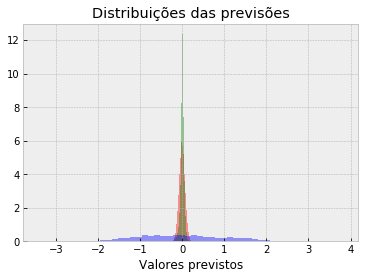

In [41]:
sns.distplot(train_pred.knn_pred, norm_hist=True,kde=False, color='r')
sns.distplot(train_pred.rf_pred, norm_hist=True,kde=False, color='g')
sns.distplot(train_pred[target], norm_hist=True, kde=False, color='b')
plt.title('Distribuições das previsões')
plt.xlabel('Valores previstos')

No *plot* acima observamos a distribuição real em azul, os valores previstos pelo modelo RandomForest em verde, e os valores previstos pelo KNN em vermelho. Infelizmente, podemos observar que as previsões ainda não generalizam bem, e se concentram em torno da média.

## Saída

In [47]:
output = pd.DataFrame(columns=['ids','spend'])
output['ids'] = test_ohe['ids'].values
output['spend'] = rf_model.predict(test_ohe[variables])
output.to_csv('spend.csv', index=False)